In [2]:
import pandas as pd
import pickle
import numpy as np

from tqdm import tqdm

## 데이터 읽어오기

In [11]:
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

DATA_PATH = '/opt/ml/input/data/train_dataset/train_data.csv'
train_df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
train_df = train_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

test_df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
test_df = test_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

In [41]:
train_df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,3.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,8.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,7.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,11.0


## time delta 계산

In [4]:
def get_timedelta(df):
    # Daily mission 방식대로 계산하면 testId 경계 부분에서 마지막 문제 값이 너무 크게 계산되므로
    # groupby 에서 testId 도 포함
    diff = df.loc[:, ['userID', 'Timestamp', 'testId']].groupby(['userID','testId']).diff().shift(-1).fillna(pd.Timedelta(seconds=0))
    diff = diff.fillna(pd.Timedelta(seconds=0))
    diff = diff['Timestamp'].apply(lambda x: x.total_seconds())
    return diff

In [ ]:
# df['elapsed'] = diff

# elapsed_answer = df.groupby('elapsed').agg({'answerCode': percentile, 'userID': 'count'})
# elapsed_hist = elapsed_answer[elapsed_answer['userID'] > 100]

In [12]:
diff = get_timedelta(test_df)

In [15]:
diff.head(10)

0     3.0
1     8.0
2     7.0
3     7.0
4    11.0
5     0.0
6     7.0
7    64.0
8    15.0
9    19.0
Name: Timestamp, dtype: float64

In [49]:
def add_timedelta(df):

    curr_id = -1
    curr_testid = -1
    START, MID, END = 0, 1, 2

    pos = [MID] * len(df)
    sol_time = [0] * len(df)
    prev_time = -1

    for i in tqdm(range(len(df))):
        # 새로운 user -> 이전 user 의 마지막 시험지 마지막 문항 처리 필요
        if df.iloc[i]['userID'] != curr_id:
            curr_id = df.iloc[i]['userID']
            curr_testid = df.iloc[i]['testId']
            prev_time = df.iloc[i]['Timestamp']
            if i > 0:
                pos[i-1] = END
            if i > 1:
                sol_time[i-1] = sol_time[i-2]
            pos[i] = START
        # 같은 user, 새로운 시험지 -> 같은 user 의 지난 시험지 마지막 문항 처리 필요
        elif curr_testid != df.iloc[i]['testId']:
            curr_testid = df.iloc[i]['testId']
            prev_time = df.iloc[i]['Timestamp']
            if i > 0:
                pos[i-1] = END
            if i > 1:
                sol_time[i-1] = sol_time[i-2]
            pos[i] = START
        # 같은 user, 같은 시험지 -> 이번 문항의 timestamp가 이전 문항을 풀기 완료한 시점으로 친다. 
        else:
            sol_time[i-1] = (df.iloc[i]['Timestamp'] - prev_time).total_seconds()
            prev_time = df.iloc[i]['Timestamp']

    df['pos'] = pos
    df['sol_seconds'] = sol_time

In [17]:
# with open('/opt/ml/input/data/train_dataset/train_timedelta.bin', 'wb') as f:
#     pickle.dump(train_df, f)

with open('/opt/ml/input/data/train_dataset/train_timedelta.bin', 'rb') as f:
    train_df = pickle.load(f)

## 결측치 파악

In [20]:
stu_groupby = train_df.groupby(['userID', 'testId']).agg({
    'assessmentItemID': ['count', pd.Series.nunique],
})

stu_groupby.head()

assessmentItemID        
                             count nunique
userID testId                             
0      A020000172                6       6
       A020000174                5       5
       A020000181                6       6
       A020000182                5       5
       A020000183                7       7

In [24]:
multi_sol = stu_groupby[stu_groupby['assessmentItemID']['count'] != stu_groupby['assessmentItemID']['nunique']]
multi_sol.head()

assessmentItemID        
                             count nunique
userID testId                             
1      A040000155               12       6
       A040000156               12       6
       A040000157               12       6
       A040000158               12       6
       A040000160               10       5

In [28]:
threshold_minutes = 20

too_long = diff[diff > threshold_minutes * 60]
print(len(too_long))
too_long.head()

22733


356    2349.0
619    3998.0
752    1688.0
762    2171.0
775    3259.0
Name: Timestamp, dtype: float64

In [29]:
diff[diff > threshold_minutes * 60] = 0

In [30]:
diff[350:360]

350     11.0
351     99.0
352     43.0
353      0.0
354    111.0
355     68.0
356      0.0
357     22.0
358     21.0
359     10.0
Name: Timestamp, dtype: float64

<AxesSubplot:ylabel='Frequency'>

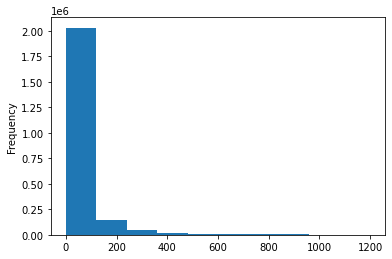

In [40]:
train_df['elapsed'] = diff
train_df['elapsed'].plot.hist()

## 결측치를 대체할 값들
- 맞았을 때, 틀렸을 때 걸린 시간 따로 기록하기

In [55]:
def nonzero_mean(s):
    num_nonzero = len(s.to_numpy().nonzero()[0])

    if num_nonzero == 0:
        return 0

    return np.sum(s) / num_nonzero

In [56]:
nonzero_mean(pd.Series([0,0,0]))

0

In [50]:
# 동일 사용자, knowledgeTag 에서 걸린 시간
def get_time_per_user_tag(df):
    tag_groupby = df.groupby(['userID', 'KnowledgeTag', 'answerCode']).agg({
        'elapsed': nonzero_mean
    })

    return tag_groupby

In [58]:
t = get_time_per_user_tag(train_df)

In [91]:
t.head()

elapsed
userID KnowledgeTag answerCode           
0      23           0           10.666667
       25           0            3.000000
       26           0            6.333333
                    1           27.000000
       30           0           30.000000

In [60]:
zero_sol = train_df[train_df['elapsed'] == 0]
print(len(zero_sol))
zero_sol.head()

395267


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
5,0,A060001007,A060000001,1,2020-03-24 00:17:47,7225,0.0
12,0,A060003007,A060000003,1,2020-03-26 05:54:11,7226,0.0
19,0,A060005007,A060000005,1,2020-03-31 05:05:48,7228,0.0
26,0,A060007007,A060000007,1,2020-04-02 05:04:08,7229,0.0
32,0,A080002006,A080000002,1,2020-04-06 00:38:05,1395,0.0


In [76]:
example = train_df.loc[(train_df['userID'] == 0) & (train_df['assessmentItemID'] == 'A060001007') & (train_df['testId'] == 'A060000001')]

if not example.empty:
    print(example['elapsed'].values)

[0.]


In [105]:
for index, row in tqdm(zero_sol.iterrows()):

    # Get replacement
    uid = row['userID']
    tag = row['KnowledgeTag']
    answer = row['answerCode']
    replace_elapsed = 0

    # groupby with multiindex
    replace = t.loc[(uid, tag, answer)]
    if not replace.empty:
        replace_elapsed = replace['elapsed']
    else:
        # answerCode 가 다르더라도 푼 적이 있으면
        replace = t.loc[(uid, tag, (answer+1) % 2)]
        if not replace.empty:
            replace_elapsed = replace['elapsed']

    if replace_elapsed > 0:
        zero_sol.at[index, ['elapsed']] = (replace_elapsed)

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
395267it [23:39, 278.43it/s]


In [108]:
# Any zeros left?
unresolved = zero_sol[zero_sol['elapsed'] == 0]
print(len(unresolved))

48173


In [109]:
# 동일 assessmentItemID 에서 다른 사용자가 걸린 시간
def get_time_per_question(df):
    tag_groupby = df.groupby(['assessmentItemID', 'answerCode']).agg({
        'elapsed': nonzero_mean
    })

    return tag_groupby

In [110]:
t2 = get_time_per_question(train_df)

In [111]:
t2.head()

elapsed
assessmentItemID answerCode           
A010001001       0           19.590909
                 1           29.196610
A010001002       0           22.076923
                 1           16.901320
A010001003       0           43.551724

In [112]:
for index, row in tqdm(unresolved.iterrows()):

    # Get replacement
    aid = row['assessmentItemID']
    answer = row['answerCode']
    replace_elapsed = 0

    # groupby with multiindex
    replace = t2.loc[(aid, answer)]
    if not replace.empty:
        replace_elapsed = replace['elapsed']
    else:
        # answerCode 가 다르더라도 푼 적이 있으면
        replace = t2.loc[(aid, (answer+1) % 2)]
        if not replace.empty:
            replace_elapsed = replace['elapsed']

    if replace_elapsed > 0:
        unresolved.at[index, ['elapsed']] = (replace_elapsed)

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
48173it [01:48, 444.28it/s]


In [114]:
zero_sol.update(unresolved)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [118]:
print(len(zero_sol[zero_sol['elapsed'] == 0]))

unresolved = zero_sol[zero_sol['elapsed'] == 0]
unresolved.head()

132


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
583,0.0,A080098008,A080000098,0.0,2020-10-06 19:25:32,1120.0,0.0
21324,28.0,A050144007,A050000144,0.0,2020-10-06 23:43:32,441.0,0.0
31856,43.0,A020033006,A020000033,0.0,2020-05-08 05:17:16,7920.0,0.0
48412,65.0,A050144007,A050000144,0.0,2020-06-15 09:37:16,441.0,0.0
56938,77.0,A050144007,A050000144,0.0,2020-10-06 08:49:31,441.0,0.0


In [119]:
# 동일 KnowledgeTag 에서 다른 사용자가 걸린 시간
def get_time_per_tag(df):
    tag_groupby = df.groupby(['KnowledgeTag', 'answerCode']).agg({
        'elapsed': nonzero_mean
    })

    return tag_groupby

In [120]:
t3 = get_time_per_tag(train_df)

In [122]:
for index, row in tqdm(unresolved.iterrows()):

    # Get replacement
    tag = row['KnowledgeTag']
    answer = row['answerCode']
    replace_elapsed = 0

    # groupby with multiindex
    replace = t3.loc[(tag, answer)]
    if not replace.empty:
        replace_elapsed = replace['elapsed']
    else:
        # answerCode 가 다르더라도 푼 적이 있으면
        replace = t3.loc[(tag, (answer+1) % 2)]
        if not replace.empty:
            replace_elapsed = replace['elapsed']

    if replace_elapsed > 0:
        unresolved.at[index, ['elapsed']] = (replace_elapsed)

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
132it [00:00, 489.38it/s]


In [123]:
print(len(unresolved[unresolved['elapsed'] == 0]))


0


In [124]:
zero_sol.update(unresolved)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [125]:
print(len(zero_sol))
print(len(zero_sol[zero_sol['elapsed'] == 0]))

395267
0


In [126]:
train_df.update(zero_sol)

In [127]:
print(len(train_df[train_df['elapsed'] == 0]))

0


In [128]:
with open('/opt/ml/input/data/train_dataset/train_timedelta_replaced.bin', 'wb') as f:
    pickle.dump(train_df, f)

## 기타

In [34]:
# 정답은 1, 오답은 0 이라 sum 을 전체 개수로 나눈 것이 정답률

def percentile(s):
    return np.sum(s) / len(s)

In [9]:
# 문항별 정답률
def get_score_per_question(df):
    prob_groupby = df.groupby('assessmentItemID').agg({
        'userID': pd.Series.nunique,  # 'count'
        'answerCode': percentile
    })

    return prob_groupby

In [10]:
# 시험지별 정답률
def get_score_per_test(df):
    test_groupby = df.groupby('testId').agg({
        'userID': pd.Series.nunique,  # 'count'
        'answerCode': percentile
    })

    return test_groupby